# Computer Vision Assignment 2
### Ashwin Rao (2019101049)

### 2.1: Corner Detection

In [122]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from PIL import Image
import os
import copy

In [123]:
# sobel filters
sobelX = np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]])

sobelY = np.array([[1, 2, 1],
                   [0, 0, 0],
                   [-1, -2, -1]])

In [124]:
# constants
RED = [255, 0, 0]
GREEN = [0, 255, 0]
BLUE = [0, 0, 255]

In [125]:
def findGaussianKernel(side=3, sigma=1.):
    """
    :param side: side of gaussian kernel
    :param sigma: sigma of gaussian kernel
    :return: gaussian kernel
    """
    
    ax = np.linspace(-(side-1)/2, (side-1)/2, side)
    
    gauss = np.exp(-0.5 * (ax ** 2) / (sigma ** 2))
    kernel = np.outer(gauss, gauss)
    
    return kernel / np.sum(kernel)

In [126]:
def findNormalKernel(side=3):
    """
    :param side: side length of normal kernel
    :return: normal kernel
    """
    
    return np.ones((side, side)) / side ** 2

In [127]:
def detectCorners(img, method='harris', window=3, thresh=0.01, k=0.05, top=10000):
    """
    :param img: image to perform corner detection
    :param method: corner detection algorithm
    :return: detected corners
    """
    
    # convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    Ix = signal.convolve2d(gray, sobelX, mode='same', boundary='symm')
    Iy = signal.convolve2d(gray, sobelY, mode='same', boundary='symm')
    
    Ixx = signal.convolve2d(Ix ** 2, findNormalKernel(window), mode='same', boundary='symm')
    Iyy = signal.convolve2d(Iy ** 2, findNormalKernel(window), mode='same', boundary='symm')
    Ixy = signal.convolve2d(Ix * Iy, findNormalKernel(window), mode='same', boundary='symm')
    
    R = np.zeros(gray.shape)
    
    # harris corner detection
    if method == 'harris':
        det = Ixx * Iyy - Ixy ** 2
        trace = Ixx + Iyy
        
        R = det - k * trace ** 2
        corners = np.array(np.where(R / np.max(R) > thresh))
        
    # shi tomasi corner detection
    elif method == 'shi-tomasi':
        h, w = gray.shape[:2]
        for i in range(h):
            for j in range(w):
                H = np.array([[Ixx[i, j], Ixy[i, j]],
                              [Ixy[i, j], Iyy[i, j]]])
                
                eigVals, _ = np.linalg.eig(H)
                R[i, j] = np.min(eigVals)
        
        R /= np.max(R)
        corners = np.c_[np.unravel_index(np.argpartition(R.ravel(), -top)[-top:], R.shape)].T
    
    # mark corners
    corner_img = img.copy()
    for i in range(np.shape(corners)[1]):
        corner_img[corners[0][i], corners[1][i]] = GREEN
    
    return corner_img, corners.T

In [128]:
def plotCorners(imgPath, method='harris'):
    """
    :param imgPath: path to image
    :param method: corner detection method
    :return: None
    """
    
    img = cv2.cvtColor(cv2.imread(imgPath), cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # detect corners
    img_corners_pred, _ = detectCorners(img, method)
    img_corners_inbuilt = img.copy()
    
    # detect corners using inbuilt method
    if method == 'harris':
        corners = cv2.cornerHarris(gray, 3, 3, 0.05)
        corners = cv2.dilate(corners, None)
        img_corners_inbuilt[corners > 0.01 * corners.max()] = GREEN
        
    elif method == 'shi-tomasi':
        corners = np.int0(cv2.goodFeaturesToTrack(gray, 100, 0.01, 10))        
        for i in corners:
            cv2.circle(img_corners_inbuilt, i.ravel(), 3, GREEN, -1)
    
    # plot images
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[20, 20])
    ax1.set_title('Original Image')
    ax1.imshow(img)

    ax2.set_title('Predicted Corners')
    ax2.imshow(img_corners_pred)

    ax3.set_title('Corners using Inbuilt function')
    ax3.imshow(img_corners_inbuilt)
    plt.show()

### Harris Corner Detector

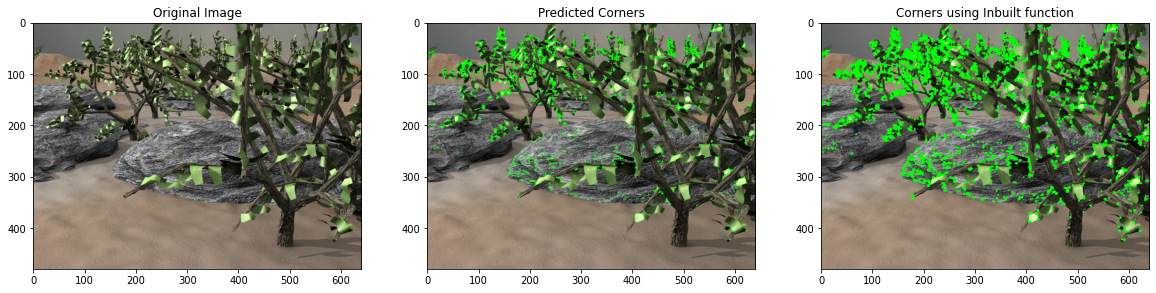

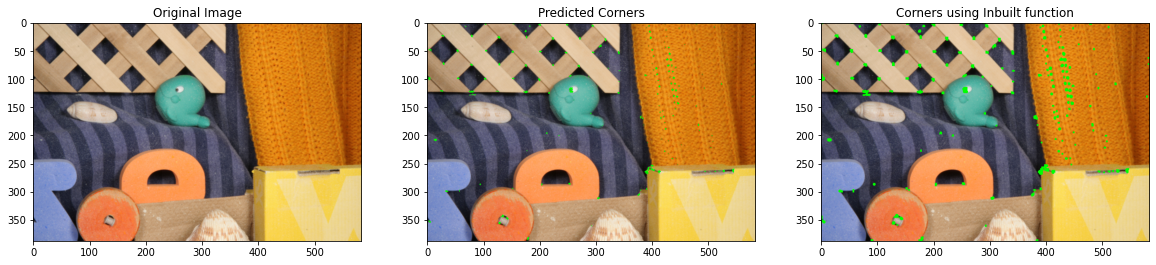

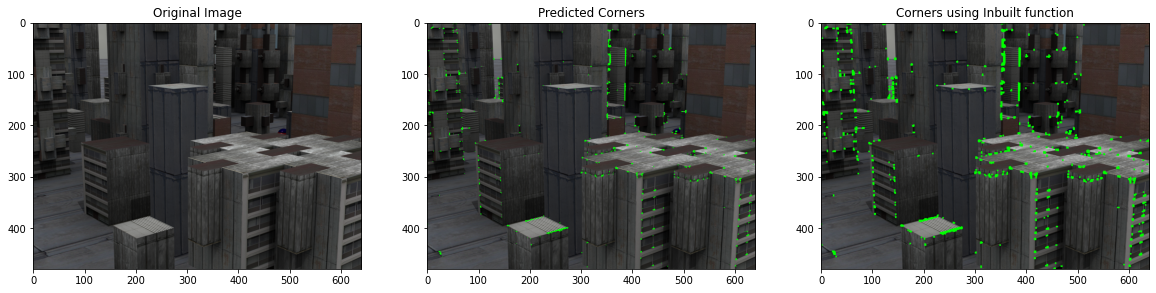

In [92]:
plotCorners('../data/all-frames-colour/Grove3/frame07.png', 'harris')
plotCorners('../data/all-frames-colour/RubberWhale/frame07.png', 'harris')
plotCorners('../data/all-frames-colour/Urban2/frame07.png', 'harris')

### Shi-Tomasi Corner Detector

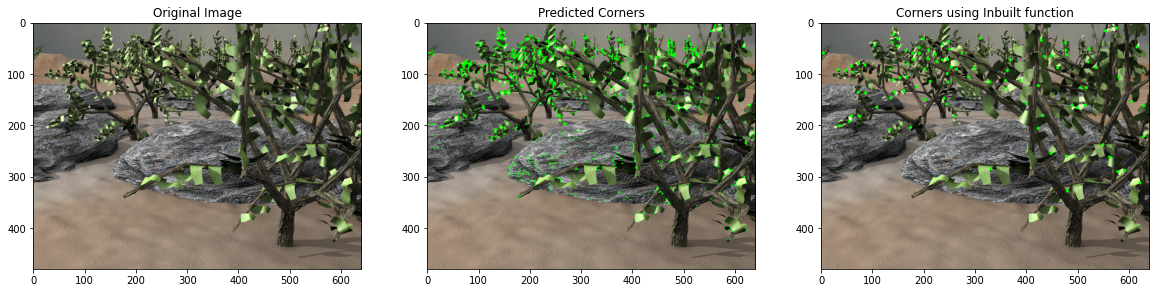

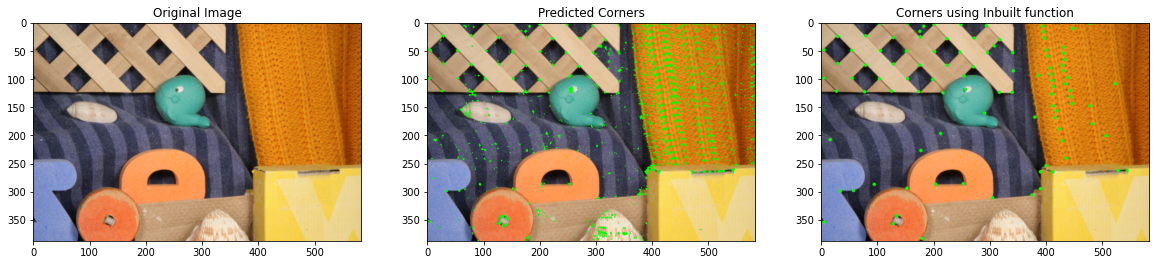

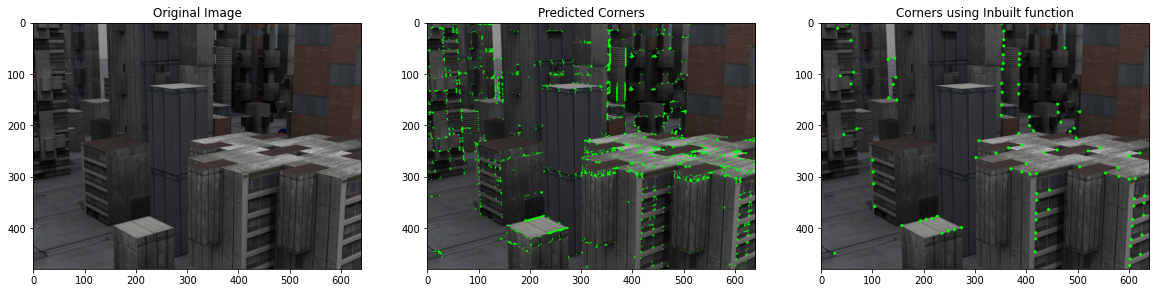

In [93]:
plotCorners('../data/all-frames-colour/Grove3/frame07.png', 'shi-tomasi')
plotCorners('../data/all-frames-colour/RubberWhale/frame07.png', 'shi-tomasi')
plotCorners('../data/all-frames-colour/Urban2/frame07.png', 'shi-tomasi')

### 2.2: Single-Scale Lucas-Kanade Algorithm

In [129]:
def readOpticalFlow(path):
    """
    :param path: path to .flo file
    :return: optical flow data
    """
    
    with open(path, "rb") as f:
        m = np.fromfile(f, np.float32, count=1)

        if m != 202021.25:
            print ("Invalid .flo file")
            return None
        
        w = int(np.fromfile(f, np.int32, count=1)[0])
        h = int(np.fromfile(f, np.int32, count=1)[0])
        data = np.fromfile(f, np.float32, count=2*w*h).reshape((h, w, 2))
    
    return data

In [130]:
def getColorWheel():
    """
    :return: color wheel according to Middlebury color code
    """
    
    RY = 15
    YG = 6
    GC = 4
    CB = 11
    BM = 13
    MR = 6

    colorwheel = np.zeros([RY + YG + GC + CB + BM + MR, 3])
    col = 0

    # RY
    colorwheel[0:RY, 0] = 255
    colorwheel[0:RY, 1] = np.floor(255 * np.arange(0, RY) / RY).T
    col += RY

    # YG
    colorwheel[col: col+YG, 0] = 255 - np.floor(255 * np.arange(0, YG) / YG).T
    colorwheel[col: col+YG, 1] = 255
    col += YG

    # GC
    colorwheel[col: col+GC, 1] = 255
    colorwheel[col: col+GC, 2] = np.floor(255 * np.arange(0, GC) / GC).T
    col += GC

    # CB
    colorwheel[col: col+CB, 1] = 255 - np.floor(255*np.arange(0, CB) / CB).T
    colorwheel[col: col+CB, 2] = 255
    col += CB

    # BM
    colorwheel[col: col+BM, 0] = np.floor(255*np.arange(0, BM) / BM).T
    colorwheel[col: col+BM, 2] = 255
    col += BM

    # MR
    colorwheel[col: col+MR, 0] = 255
    colorwheel[col: col+MR, 2] = 255 - np.floor(255 * np.arange(0, MR) / MR).T

    return colorwheel

In [131]:
def findOpticalFlowColorMap(u, v):
    """
    :param u: optical flow map (horizontal)
    :param v: optical flow map (vertical)
    :return: optical flow color map
    """
    
    # define output image
    h, w = u.shape
    img = np.zeros((h, w, 3))
    
    # convert NANs to zeros
    nanIdx = np.isnan(u) | np.isnan(v)
    u[nanIdx] = 0
    v[nanIdx] = 0

    # get color wheel
    colorwheel = getColorWheel()
    num_cols = colorwheel.shape[0]
    
    # define values
    rad = (u ** 2 + v ** 2) ** 0.5
    
    a = np.arctan2(-v, -u) / np.pi
    fk = (a + 1) / 2 * (num_cols - 1) + 1
    k0 = np.floor(fk).astype(int)

    k1 = k0 + 1
    k1[k1 == num_cols + 1] = 1
    f = fk - k0

    for i in range(0, colorwheel.shape[1]): 
        col0 = colorwheel[:, i][k0 - 1] / 255
        col1 = colorwheel[:, i][k1 - 1] / 255
        col = (1 - f) * col0 + f * col1

        j = rad <= 1
        col[j] = 1 - rad[j] * (1 - col[j])
        not_j = np.logical_not(j)

        col[not_j] *= 0.75
        img[:, :, i] = np.uint8(np.floor(255 * col * (1 - nanIdx)))

    return img

In [132]:
def getImageFromFlow(flow, thresh=1e7):
    """
    :param flow: optical flow color map
    :return: optical flow image in middlebury color code
    """
    
    # extract u and v from flow
    u = flow[:, :, 0]
    v = flow[:, :, 1]
    
    # convert values above threshold to 0
    j = (abs(u) > thresh) | (abs(v) > thresh)
    u[j] = 0
    v[j] = 0

    rad = np.sqrt(u ** 2 + v ** 2)
    max_rad = max(-1, np.max(rad))
    
    epsilon = np.finfo(float).eps
    u /= max_rad + epsilon
    v /= max_rad + epsilon

    img = findOpticalFlowColorMap(u, v).astype(np.uint8)
    img[np.repeat(j[:, :, np.newaxis], 3, axis=2)] = 0
    
    return img

In [137]:
def LucasKanade(img1, img2, windowSize=[5, 5], thresh=0.01):
    """
    :param img1: first image (grayscale and normalized)
    :param img2: second image (grayscale and normalized)
    :return: optical flow
    """
    
    h, w = img1.shape[:2]
    
    dx = signal.correlate2d(img1, sobelX, mode='same', boundary='symm')
    dy = signal.correlate2d(img1, sobelY, mode='same', boundary='symm')
    
    dxx = dx ** 2
    dyy = dy ** 2
    dxy = dx * dy
    
    dt = img2 - img1
    dxt = dx * dt
    dyt = dy * dt
    
    dxx = signal.convolve2d(dxx, np.ones(windowSize), mode='same', boundary='symm')
    dyy = signal.convolve2d(dyy, np.ones(windowSize), mode='same', boundary='symm')
    dxy = signal.convolve2d(dxy, np.ones(windowSize), mode='same', boundary='symm')
    dxt = signal.convolve2d(dxt, np.ones(windowSize), mode='same', boundary='symm')
    dyt = signal.convolve2d(dyt, np.ones(windowSize), mode='same', boundary='symm')
    
    flow = np.zeros((h, w, 2))
    pts = []
    
    for i in range(img1.shape[0]):
        for j in range(img1.shape[1]):
            ATA = np.array([[dxx[i, j], dxy[i, j]],
                          [dxy[i, j], dyy[i, j]]])
            
            b = np.array([[-dxt[i, j]], 
                          [-dyt[i, j]]])
            
            eigVals, _ = np.linalg.eig(ATA)
            if np.min(eigVals) > thresh:
                flow[i, j, :] = (np.linalg.inv(ATA) @ b).T
                pts.append([i, j])
    
    return flow, pts

In [138]:
def plotFlow(dir_name):
    """
    :param dir_name: name of directory
    """
    
    img_path1 = f'../data/all-frames-colour/{dir_name}/frame07.png'
    img_path2 = f'../data/all-frames-colour/{dir_name}/frame08.png'
    flow_path = f'../data/ground-truth-flow/{dir_name}/flow10.flo'
    
    # read images
    img1 = cv2.cvtColor(cv2.imread(img_path1), cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(cv2.imread(img_path2), cv2.COLOR_BGR2RGB)
    
    # convert to grayscale
    gray1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
    
    # normalize
    gray1 = (gray1 - np.mean(gray1)) / 255
    gray2 = (gray2 - np.mean(gray2)) / 255
    
    # predict flow
    pred_flow, _ = LucasKanade(gray1, gray2, [15, 15], 0.005)
    pred_flow_img = getImageFromFlow(pred_flow)
    
    # ground truth flow
    ground_truth_flow = readOpticalFlow(flow_path)
    ground_truth_flow_img = getImageFromFlow(ground_truth_flow)
    
    # plot images
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[20, 20])
    
    ax1.set_title('Predicted Quiver Plot')
    ax1.imshow(img1)
    
    _, corners = detectCorners(img1, 'shi-tomasi', top=1000)
    for i in range(corners.shape[0]):
        row = corners[i][0]
        col = corners[i][1]
        ax1.quiver(col, row, pred_flow[row, col, 0], pred_flow[row, col, 1], scale=4)
    
    ax2.set_title('Predicted Flow')
    ax2.imshow(pred_flow_img)

    ax3.set_title('Ground Truth Flow')
    ax3.imshow(ground_truth_flow_img)
    plt.show()
    
    print("Error: ", findError(pred_flow, ground_truth_flow))

In [139]:
def findError(flow, ground_truth_flow):
    """
    :param flow: predicted flow
    :param ground_truth_flow: ground truth flow
    :return: error in flow
    """
    
    epe = []
    for i in range(flow.shape[0]):
        for j in range(flow.shape[1]):
            epe.append(np.linalg.norm(ground_truth_flow[i, j] - flow[i, j]))
            
    return np.mean(epe)

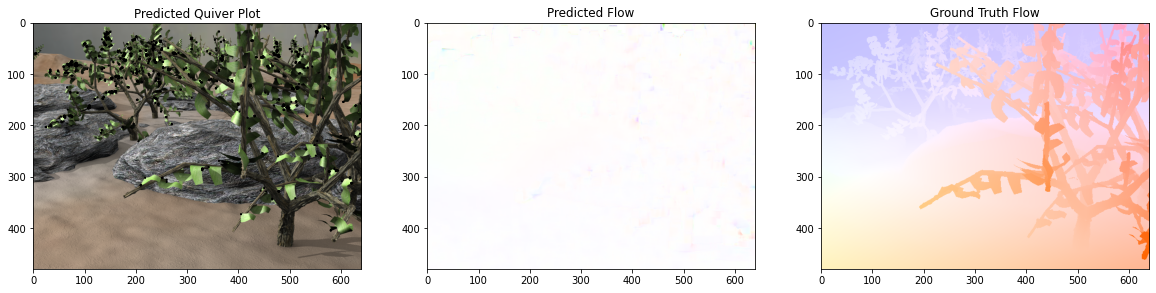

Error:  0.21079976154757732


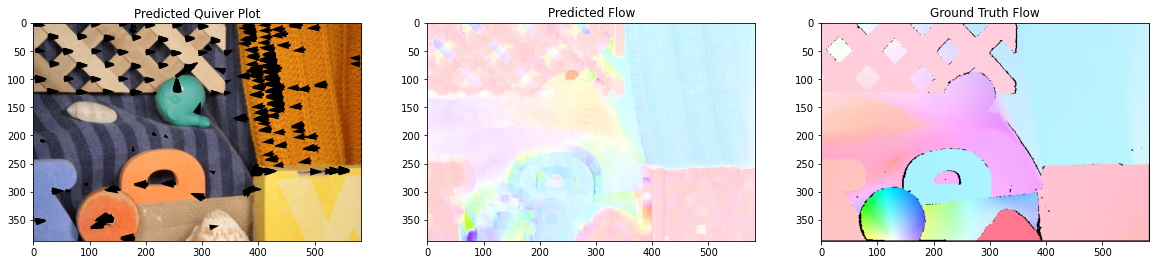

Error:  0.17687034558450465


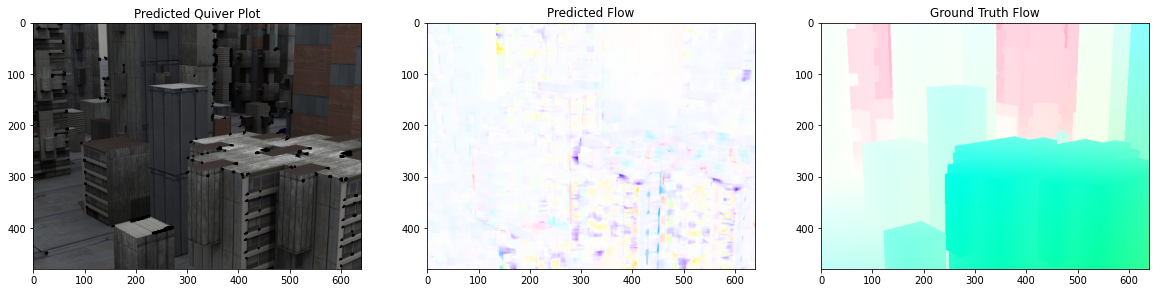

Error:  0.38068948603649067


In [140]:
plotFlow('Grove3')
plotFlow('RubberWhale')
plotFlow('Urban2')

In [141]:
def mergeFramesIntoVideo(img_path, video_path, match, fps=None):
    """
    :param img_path: path to directory containing images to merge
    :param video_path: path to video to write to
    :param match: string to match images to include in video
    """
    
    filename = os.listdir(img_path)[0]

    video = cv2.VideoCapture(os.path.join(img_path, match))
    width = int(video.get(3))
    height = int(video.get(4))
    if fps is None:
        fps = int(video.get(5))

    out = cv2.VideoWriter(video_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

    # process each frame
    while True:
        ret, frame = video.read()
        if not ret:
            break

        # write frame to video
        out.write(frame)

    video.release()
    out.release()

In [101]:
def generateFlowVideo(dir_name):
    """
    :param dir_name: name of directory containing sequence
    """
    
    # get list of paths to images
    img_dir = f'../data/all-frames-colour/{dir_name}/'
    files = sorted(os.listdir(img_dir))
    img_paths = [os.path.join(img_dir, f) for f in files]
        
    # ground truth flow
    flow_path = f'../data/ground-truth-flow/{dir_name}/flow10.flo'
    ground_truth_flow_img = getImageFromFlow(readOpticalFlow(flow_path))
    
    # predicted flows
    for i in range(len(img_paths) - 1):
        img_path1 = img_paths[i]
        img_path2 = img_paths[i + 1]
        
        # load images
        img1 = cv2.cvtColor(cv2.imread(img_path1), cv2.COLOR_BGR2RGB)
        img2 = cv2.cvtColor(cv2.imread(img_path2), cv2.COLOR_BGR2RGB)
        
        # predict flow
        pred_flow, _ = LucasKanade(img1, img2, [15, 15], 0.005)
        pred_flow_img = getImageFromFlow(pred_flow)
        
        # save image
        save_path = f'../results/2.2/{dir_name}/flow{str(i).zfill(3)}.png'
        cv2.imwrite(save_path, pred_flow_img)
        
        # show quiver plot
        plt.figure(figsize=[10, 10])
        plt.title('Predicted Quiver Plot')
        plt.imshow(img1)
    
        _, corners = detectCorners(img1, 'shi-tomasi', top=1000)
        for j in range(corners.shape[0]):
            row = corners[j][0]
            col = corners[j][1]
            plt.quiver(col, row, pred_flow[row, col, 0], pred_flow[row, col, 1], scale=5)
        
        # save quiver plot
        quiver_save_path = f'../results/2.2/{dir_name}/quiver{str(i).zfill(3)}.png'
        plt.savefig(quiver_save_path)
        plt.show()
    
    # save videos
    mergeFramesIntoVideo(f'../results/2.2/{dir_name}/', 
                         f'../results/2.2/{dir_name}/flow.mp4', 'flow%03d.png')
    
    mergeFramesIntoVideo(f'../results/2.2/{dir_name}/', 
                         f'../results/2.2/{dir_name}/quiver.mp4', 'quiver%03d.png')

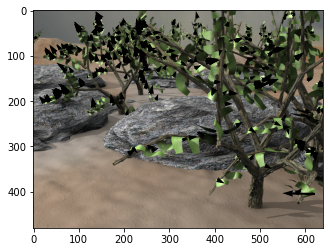

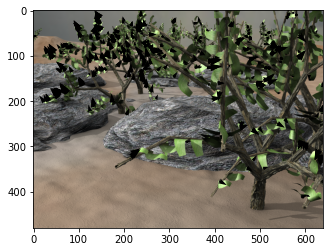

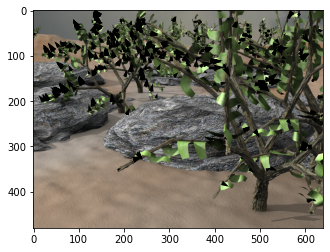

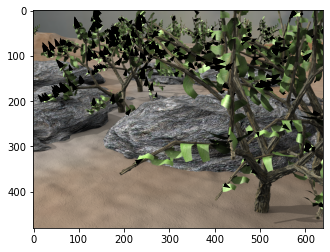

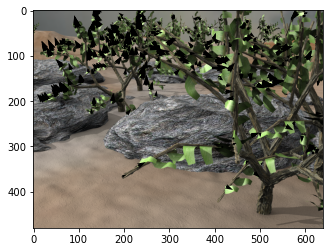

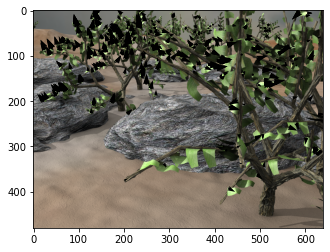

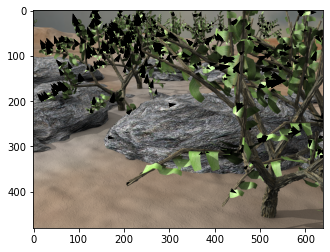

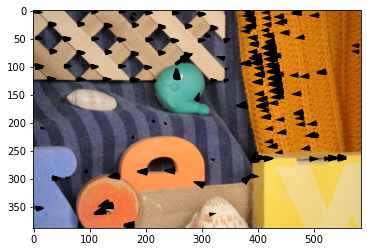

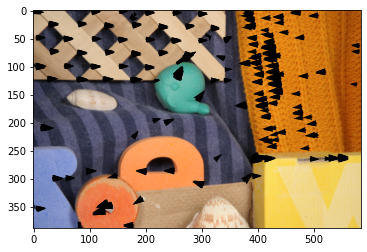

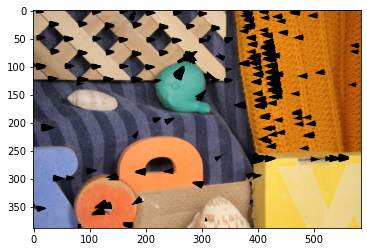

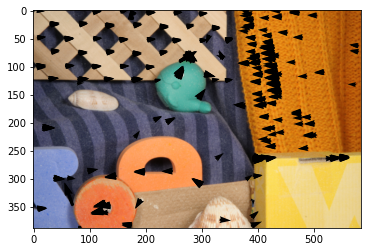

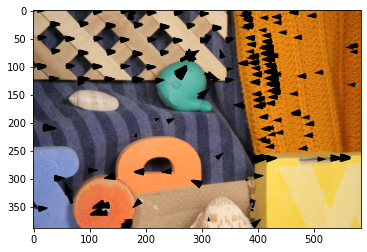

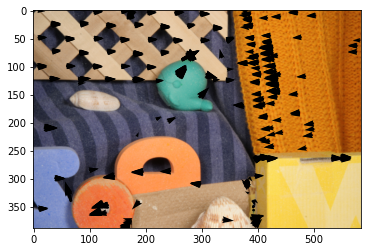

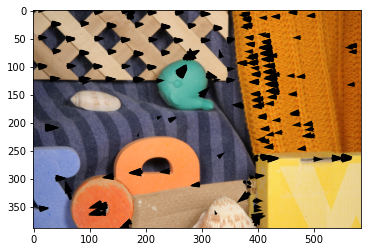

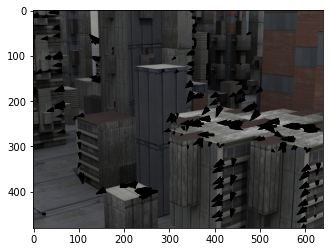

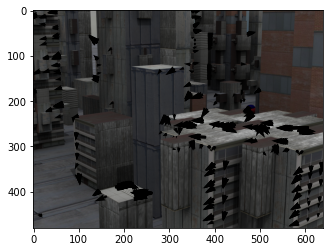

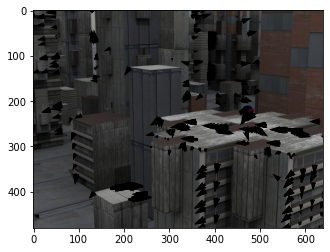

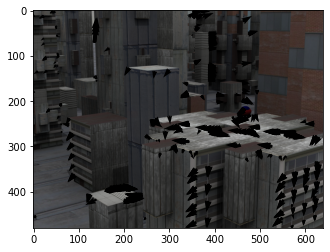

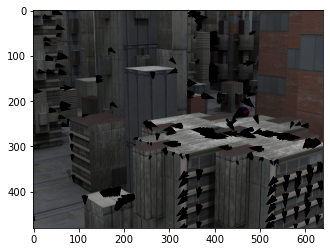

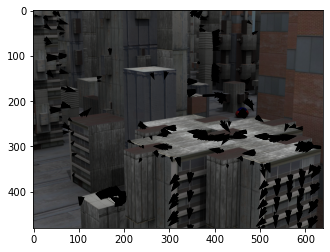

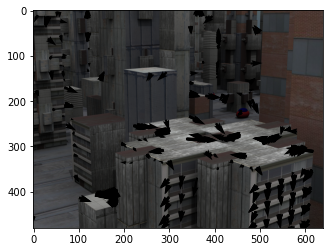

In [55]:
generateFlowVideo('Grove3')
generateFlowVideo('RubberWhale')
generateFlowVideo('Urban2')

### 3

In [168]:
def refineFlow(img1, img2, windowSize=[5, 5], u0=None, v0=None, thresh=0.01):
    """
    :param img1: first image (grayscale and normalized)
    :param img2: second image (grayscale and normalized)
    :return: optical flow
    """
    
    h, w = img2.shape[:2]
    
    opt_flow = np.zeros((h, w, 2))
    if u0 is not None:
        opt_flow[:, :, 0] = np.array(u0)
    if v0 is not None:
        opt_flow[:, :, 1] = np.array(v0)    
    
    new_img2 = np.zeros((h, w))
    for r in range(h):
        for c in range(w):
            new_r = r + round(opt_flow[r, c, 1])
            new_c = c + round(opt_flow[r, c, 0])
            
            # clamp new_r to [0, h-1]
            if new_r > h - 1: 
                new_r = h - 1
            elif new_r < 0:
                new_r = 0
            
            # clamp new_c to [0, w-1]
            if new_c > w - 1:
                new_c = w - 1  
            elif new_c < 0:
                new_c = 0
            
            new_img2[r, c] = img2[new_r, new_c]
     
    return LucasKanade(img1, new_img2, windowSize, thresh)

In [169]:
def MultiScaleLucasKanade(img1, img2, windowSize=[5, 5], levels=1, thresh=0.01):
    """
    :param img1: first image (grayscale and normalized)
    :param img2: second image (grayscale and normalized)
    :return: optical flow
    """
    
    h, w = img1.shape[:2]
    
    s1 = signal.convolve2d(img1, findGaussianKernel(5, 1), mode='same', boundary='symm')
    s2 = signal.convolve2d(img2, findGaussianKernel(5, 1), mode='same', boundary='symm')
    
    flow = None
    pts = []
    
    for i in range(levels):
        skip_val = 2 ** (levels - i - 1)
        nextFlow = [None, None]
        
        if flow is not None:
            rows = h // skip_val + (h % skip_val > 0)
            cols = w // skip_val + (w % skip_val > 0)
            
            nextFlow[0] = np.zeros((rows, cols))
            nextFlow[0][::2, ::2] = flow[:, :, 0]
            
            nextFlow[1] = np.zeros((rows, cols))
            nextFlow[1][::2, ::2] = flow[:, :, 1]
        
        flow, pts = refineFlow(s1[::skip_val, ::skip_val], s2[::skip_val, ::skip_val], 
                               windowSize, nextFlow[0], nextFlow[1], thresh)
            
    return flow, pts

In [170]:
def plotFlowOpt(dir_name):
    """
    :param dir_name: name of directory
    """
    
    img_path1 = f'../data/all-frames-colour/{dir_name}/frame07.png'
    img_path2 = f'../data/all-frames-colour/{dir_name}/frame08.png'
    flow_path = f'../data/ground-truth-flow/{dir_name}/flow10.flo'
    
    # read images
    img1 = cv2.cvtColor(cv2.imread(img_path1), cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(cv2.imread(img_path2), cv2.COLOR_BGR2RGB)
    
    # convert to grayscale
    gray1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
    
    # normalize
    gray1 = (gray1 - np.mean(gray1)) / 255
    gray2 = (gray2 - np.mean(gray2)) / 255
    
    # predict flow
    pred_flow, _ = MultiScaleLucasKanade(gray1, gray2, [15, 15], thresh=0.005)
    pred_flow_img = getImageFromFlow(pred_flow)
    
    # ground truth flow
    ground_truth_flow = readOpticalFlow(flow_path)
    ground_truth_flow_img = getImageFromFlow(ground_truth_flow)
    
    # plot images
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[20, 20])
    
    ax1.set_title('Predicted Quiver Plot')
    ax1.imshow(img1)
    
    _, corners = detectCorners(img1, 'shi-tomasi', top=1000)
    for i in range(corners.shape[0]):
        row = corners[i][0]
        col = corners[i][1]
        ax1.quiver(col, row, pred_flow[row, col, 0], pred_flow[row, col, 1], scale=5)
    
    ax2.set_title('Predicted Flow')
    ax2.imshow(pred_flow_img)

    ax3.set_title('Ground Truth Flow')
    ax3.imshow(ground_truth_flow_img)
    plt.show()
    
    print("Error: ", findError(pred_flow, ground_truth_flow))

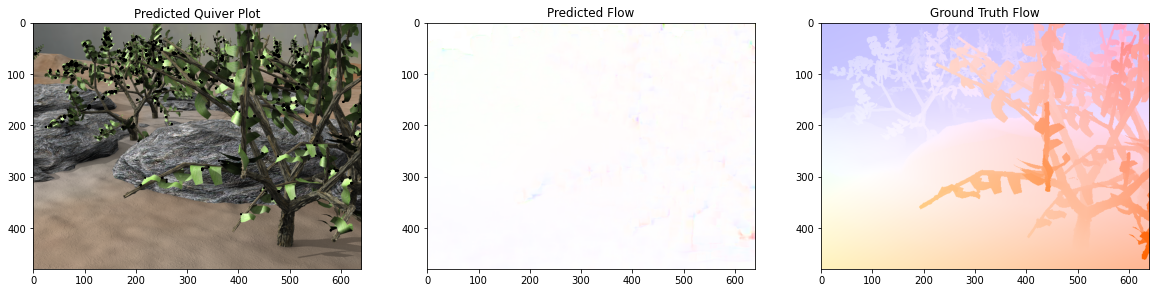

Error:  0.21017607275645153


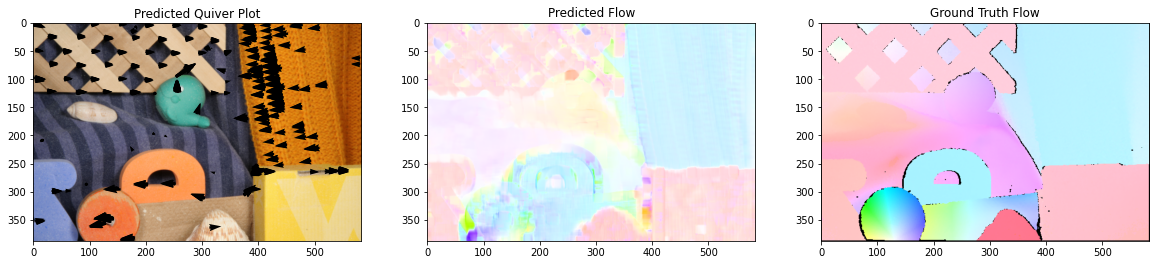

Error:  0.1853453192148797


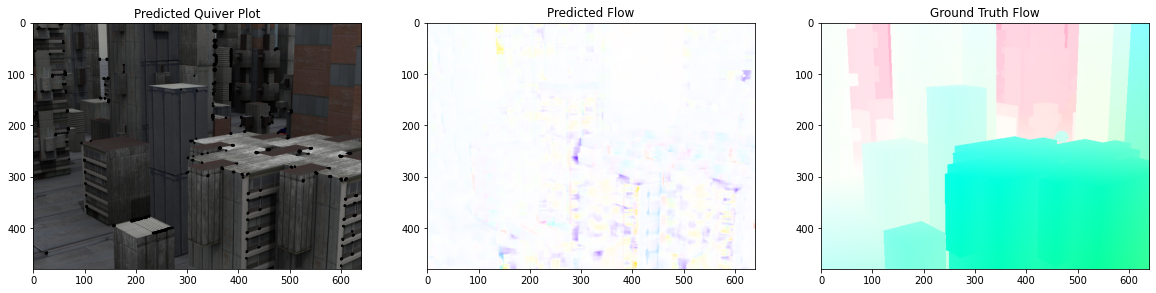

Error:  0.3766062372998984


In [171]:
plotFlowOpt('Grove3')
plotFlowOpt('RubberWhale')
plotFlowOpt('Urban2')